## E9-13. 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

### 학습목표
---
* 다양한 하이퍼 파라미터를 튜닝하며 최적의 조합을 찾아본다

#### 시도해 볼 수 있는 방법
---

* 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
* LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
* 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
* Baseline 커널에서 활용했던 블렌딩 방법 활용하기

#### 프로젝트 루브릭
---

* 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
* 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
* 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

### 1. 데이터 불러오기

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join
import gc


import pandas as pd
import numpy as np
from scipy import stats
import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


#### 1-1. 데이터 확인 및 이해

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))


train data dim : (15035, 21)
test data dim : (6468, 20)


In [4]:
# head를 통해서는 변수를 이해해보고, 변수를 살펴보면서 전처리해야 할 부분과 피쳐 엔지니어링을 할 아이디어를 고민해본다.

train.head()

# date 값 정리 필요해 보임. 필요한 부분은 앞의 6자리
# yr_renovated, view, waterfront 의 값은 이진 분류로 보임. (리노베이션을 했다:1 / 하지 않았다:0)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 1-2. 목적 변수 분석

In [5]:
train['price'].describe() #pd의 다양한 통계량을 요약해주는 굉장히 편리한 메서드

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

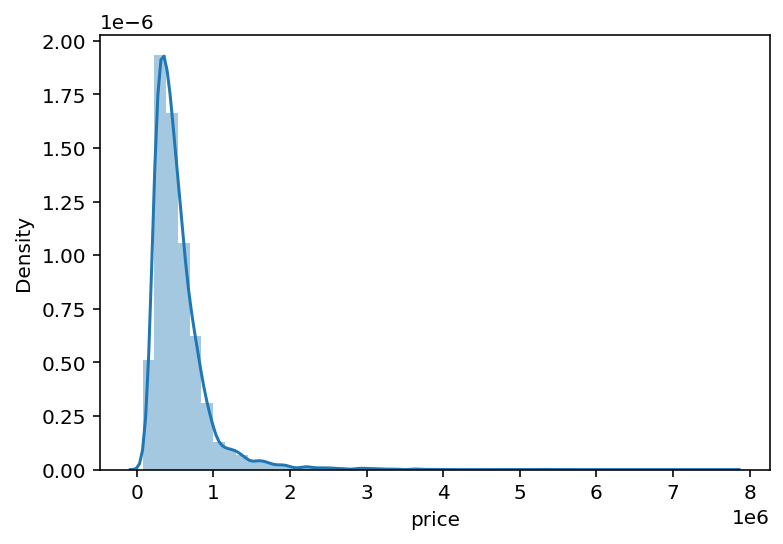

In [6]:
sns.distplot(train['price'])
#목적변수 price의 분포도를 sns로 확인해 보니, 값이 치우쳐 있다. 

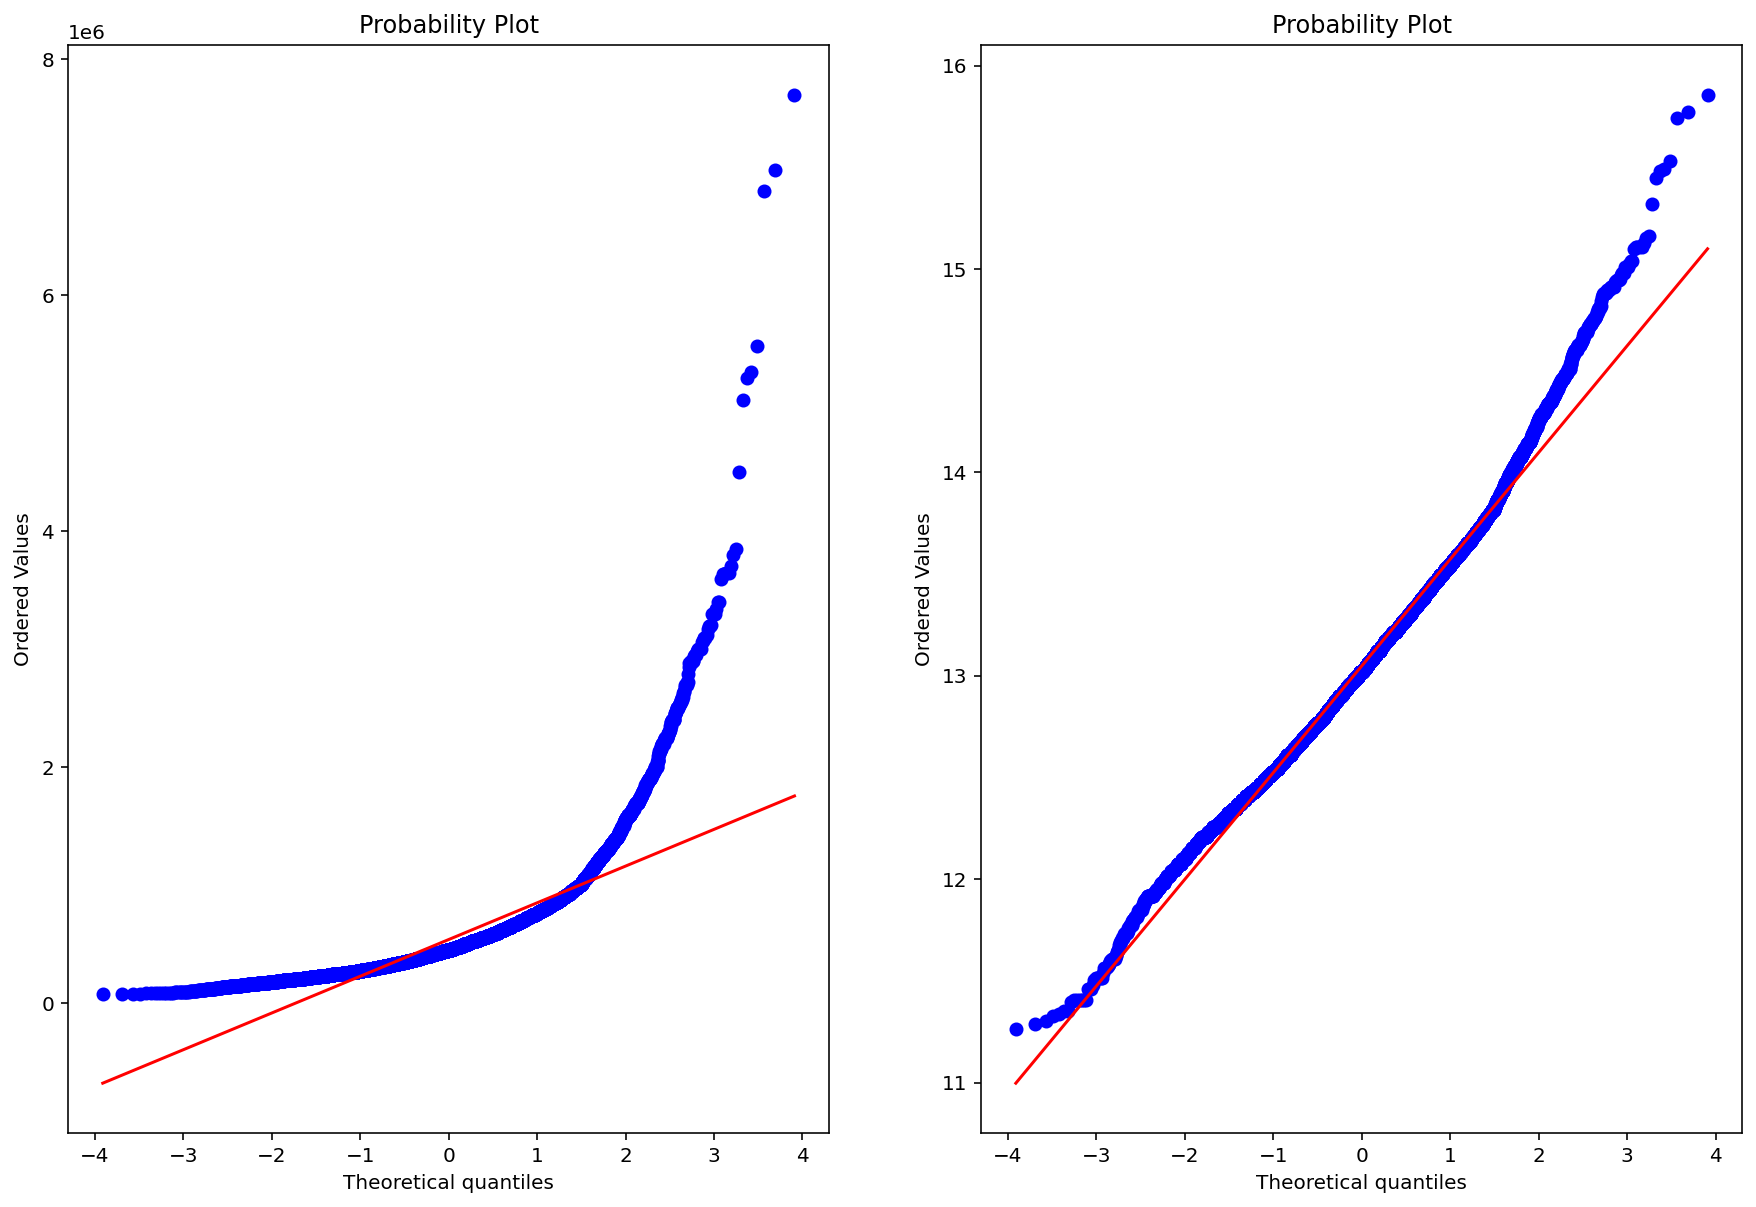

In [7]:
fig = plt.figure(figsize = (15, 10))

fig.add_subplot(1, 2, 1)
res = stats.probplot(train['price'], plot=plt)

fig.add_subplot(1, 2, 2)
res = stats.probplot(np.log1p(train['price']), plot=plt)

**왜도와 첨도**

왜도 : 오른쪽 꼬리가 길수록 값이 더 큽니다.
첨도 (kurtosis / kurtosis) : 첨도 값 (K)이 3에 가까울 경우, scatter은 정규 분포에 가깝습니다. (K <3), 분포가 정규 분포보다 더 평탄하게 평탄하다고 판단 할 수 있으며, 첨도가 3보다 큰 양수인 경우 (K> 3), 분포가보다 뾰족한 분포로 간주 할 수 있습니다.

목적변수 'price'의 경우 첨도, 왜도도 굉장히 정규분포를 따르지않고, 분산 또한 매우 큰 것을 확인할 수 있습니다. 
Normalize를 통해 price의 분포가 정규분포를 가지도록 만들겠습니다.

 #### 1-3.목적변수 normalizing

<AxesSubplot:xlabel='price', ylabel='Density'>

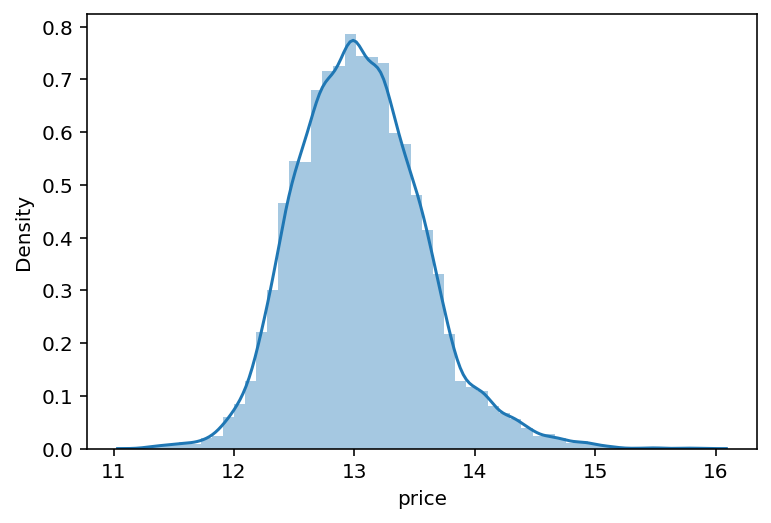

In [8]:
train['price'] = np.log1p(train['price'])
sns.distplot(train['price'])


#### 1-4. 목적변수  PRICE에 대한 반응변수의  상관 관계 분석
* 스피어만 순위 상관관계를 기준으로 목적변수와 상관도가 높은 상위 10개의 반응변수 시각화

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot' 'long' 'sqft_lot15' 'id' 'condition'
 'zipcode']


<AxesSubplot:>

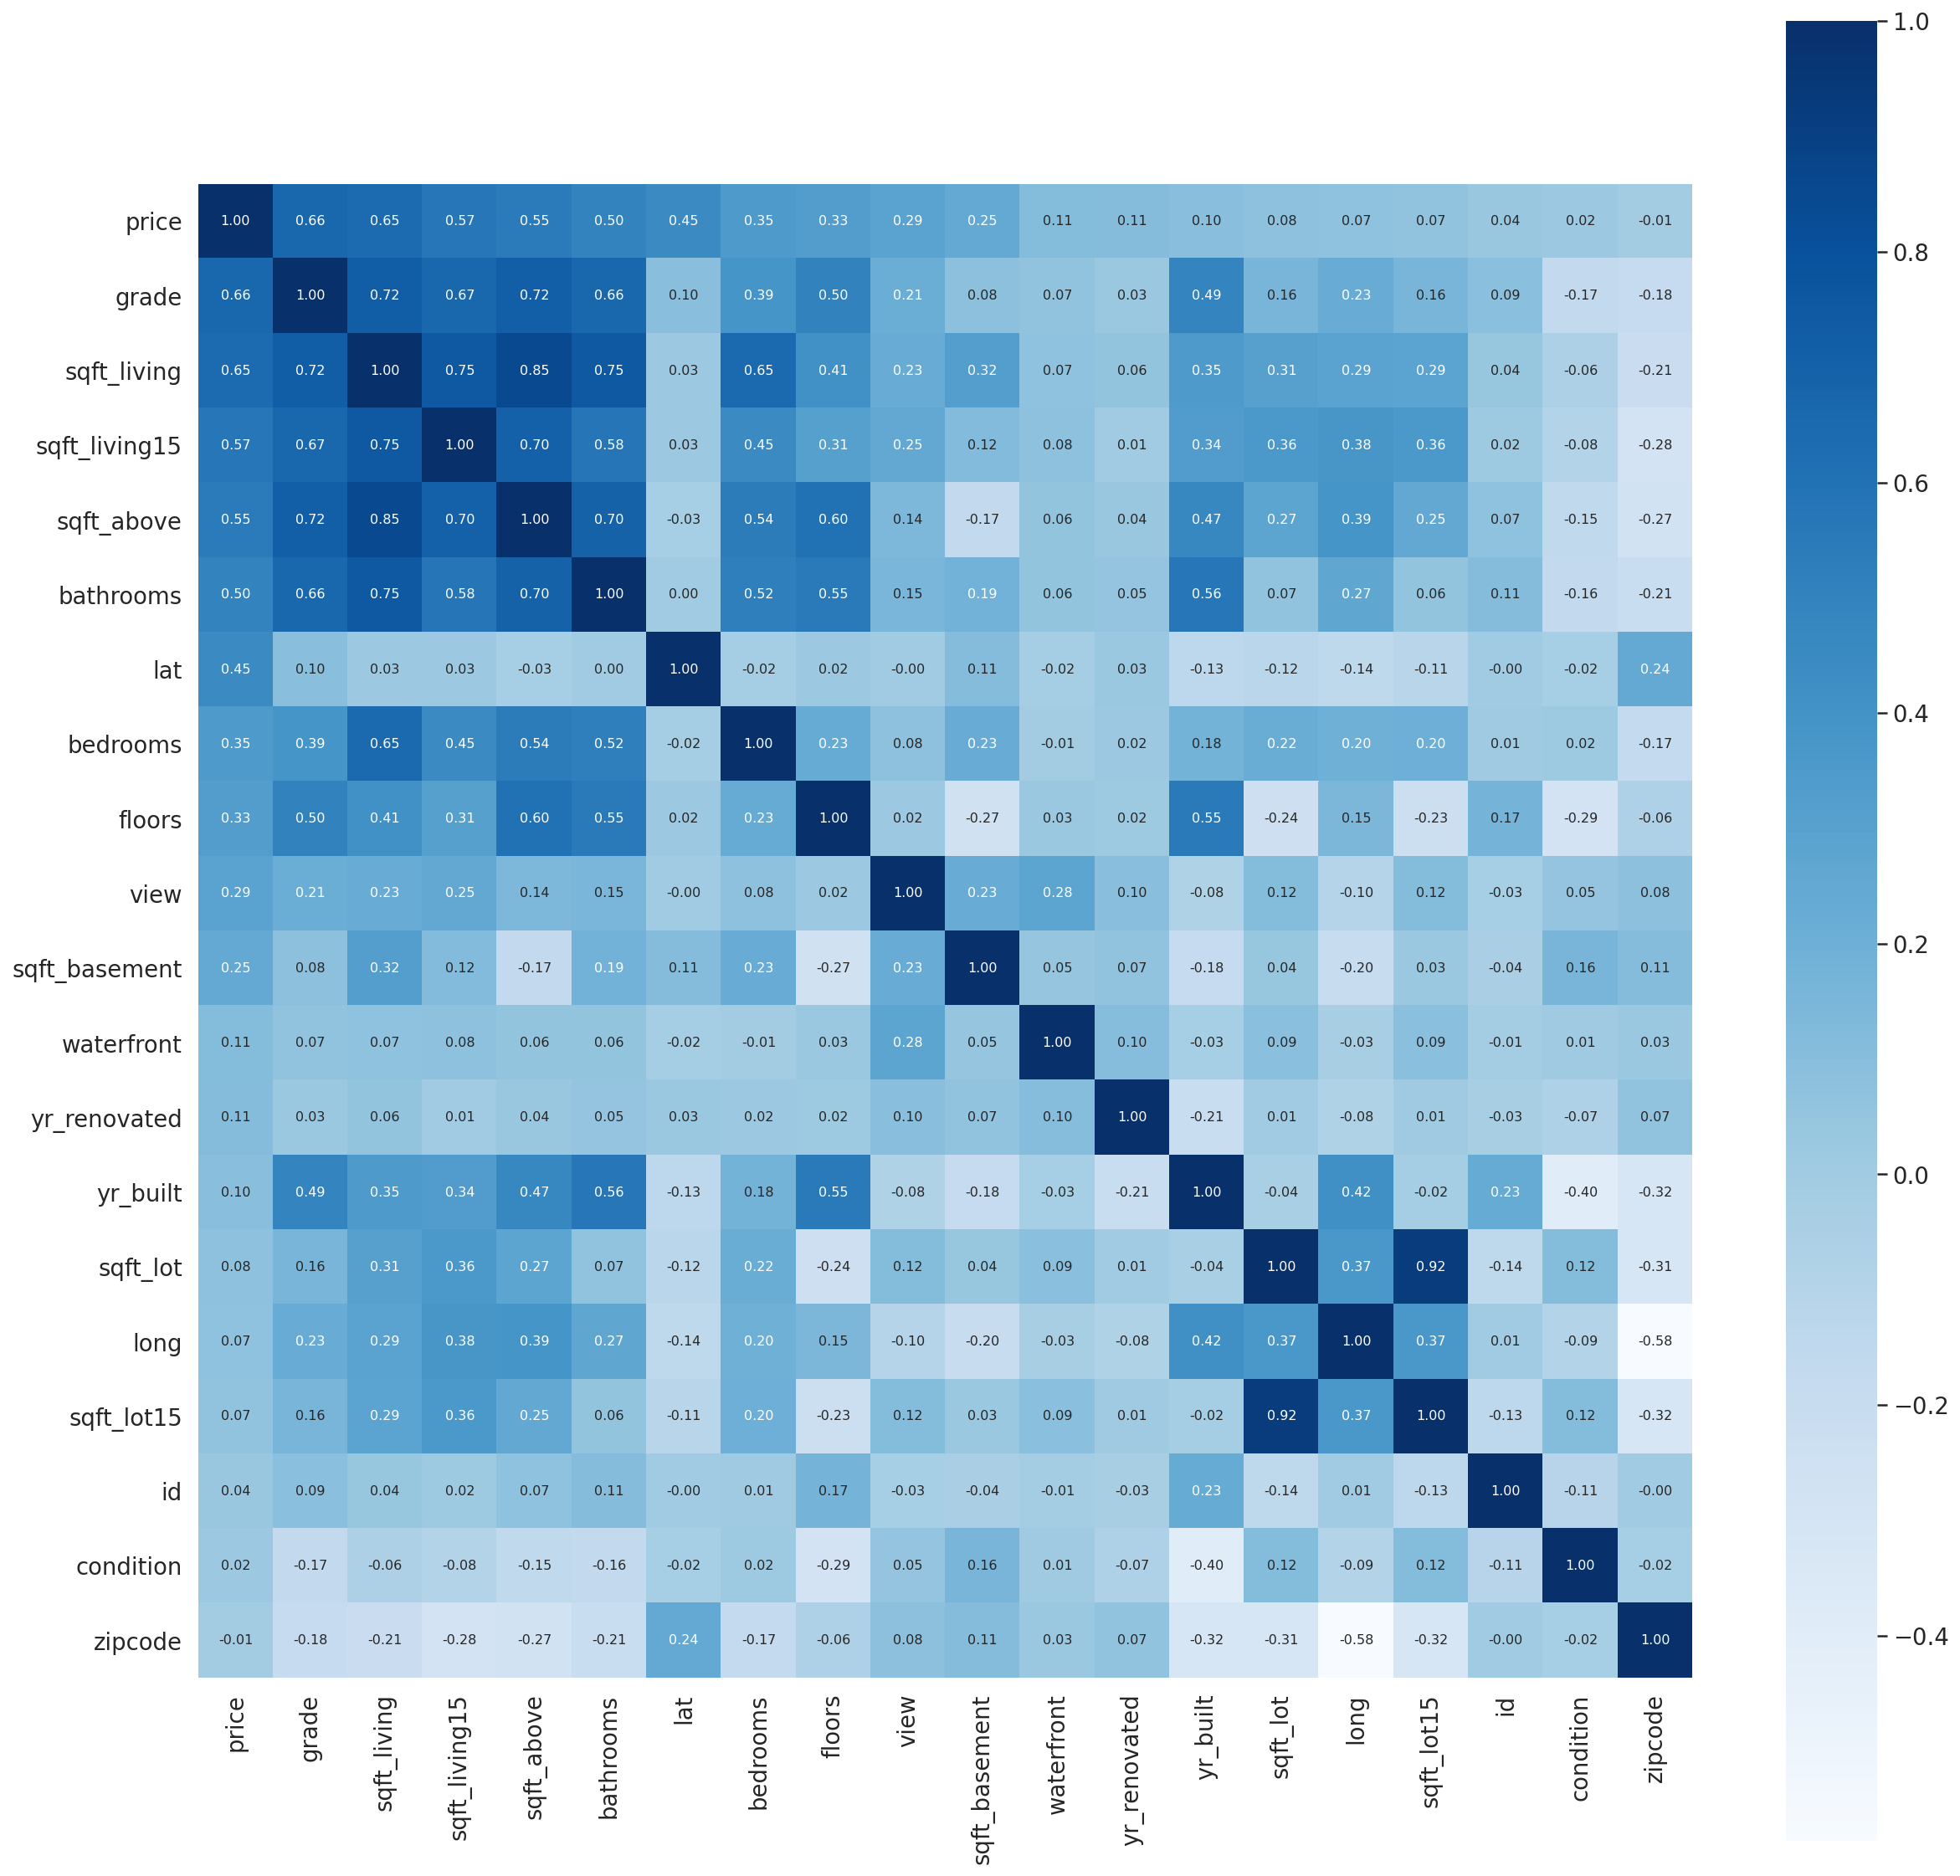

In [9]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=20, columns='price').index

cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
print(cor_cols.values)

plt.figure(figsize=(20, 20))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True, cmap='Blues', annot_kws={'size' : 8}, xticklabels=cor_cols.values, yticklabels=cor_cols.values)

**목적변수와 상관도가 높은 변수는 grade - sqft_living - sqft_living15 -sqft_above-bathrooms 순임을 알 수 있다.**

#### 1-5.아웃라이어 (이상치) 식별 및 정리
* Grade 컬럼
<br>위에서 확인한것처럼 목적변수에 상관관계가 높은 grade컬럼의 이상치를 확인하여 데이터를 다듬어 준다.</br>

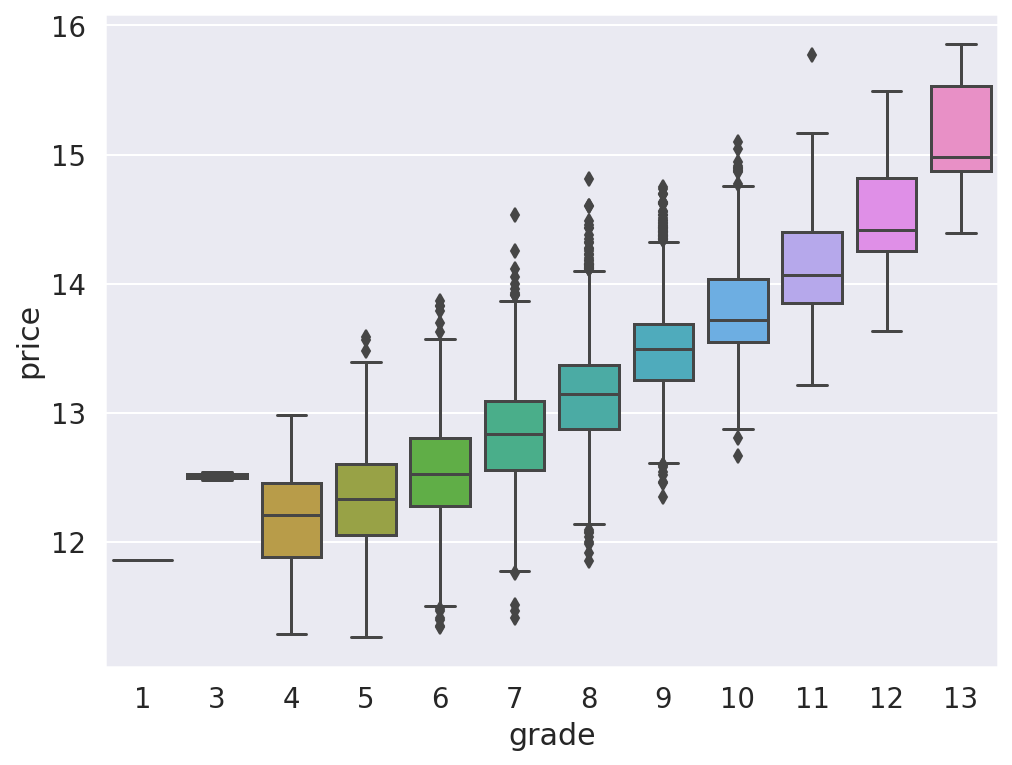

In [10]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x='grade', y='price', data=data)

In [11]:
train.loc[(train['price']>12) & (train['grade'] <= 3)  ][cor_cols]

,price,grade,sqft_living,sqft_living15,sqft_above,bathrooms,lat,bedrooms,floors,view,sqft_basement,waterfront,yr_renovated,yr_built,sqft_lot,long,sqft_lot15,id,condition,zipcode
2302,12.476104,3,520,1340,520,0.75,47.2082,1,1.0,0,0,0,0,1920,12981,-121.995,12233,2302,5,98022
4123,12.542548,3,600,990,600,0.00,47.5316,1,1.0,0,0,0,0,1950,24501,-121.749,22549,4123,2,98045


In [12]:
train.loc[(train['price']>15.5) & (train['grade'] == 11)][cor_cols] 

,price,grade,sqft_living,sqft_living15,sqft_above,bathrooms,lat,bedrooms,floors,view,sqft_basement,waterfront,yr_renovated,yr_built,sqft_lot,long,sqft_lot15,id,condition,zipcode
2775,15.77031,11,10040,3930,7680,4.5,47.65,5,2.0,2,2360,1,2001,1940,37325,-122.214,25449,2775,3,98004


In [13]:
train = train.loc[train['id'] != 2302]
train = train.loc[train['id'] != 4123]
train = train.loc[train['id'] != 2775]

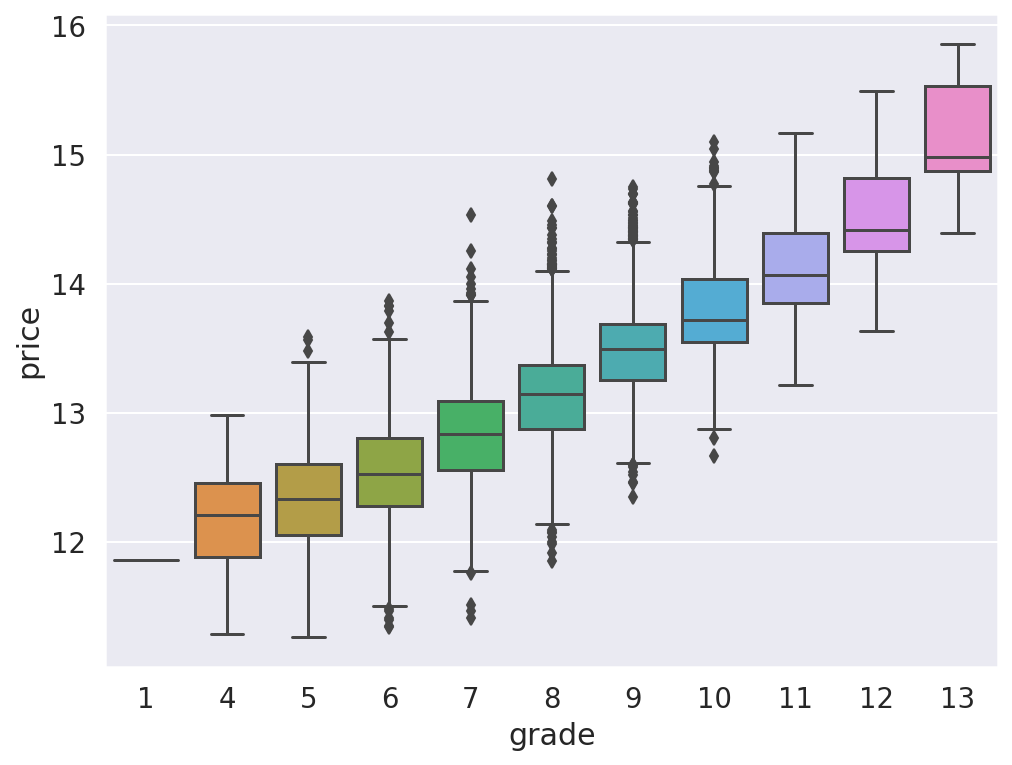

In [14]:
# 이상치 제거 확인
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x='grade', y='price', data=data)

* sqft_living 이상치 확인

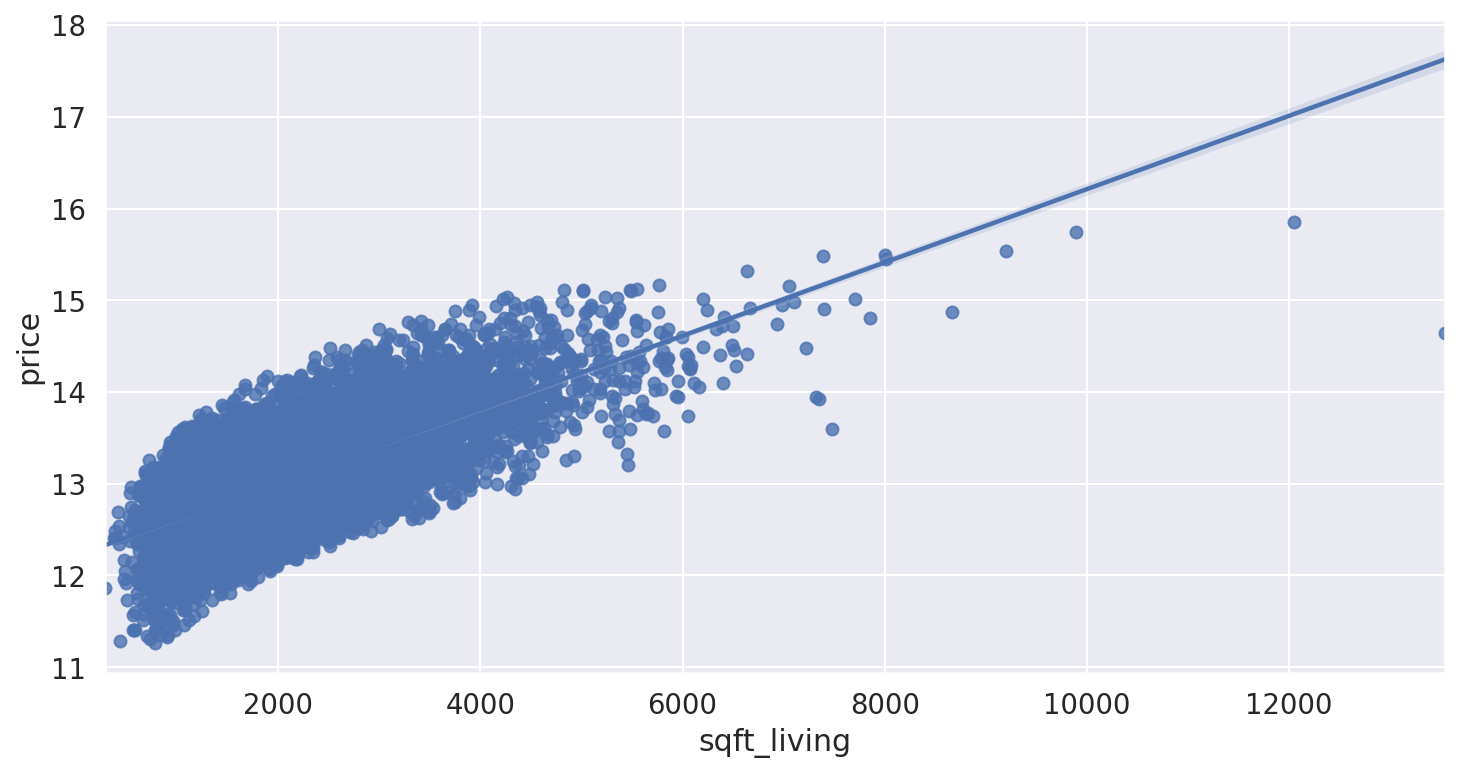

In [15]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(12,6))
fig = sns.regplot(x='sqft_living', y='price', data=data)

In [16]:
train.loc[train['sqft_living']>13000][cor_cols]

,price,grade,sqft_living,sqft_living15,sqft_above,bathrooms,lat,bedrooms,floors,view,sqft_basement,waterfront,yr_renovated,yr_built,sqft_lot,long,sqft_lot15,id,condition,zipcode
8912,14.639686,12,13540,4850,9410,8.0,47.6675,7,3.0,4,4130,0,0,1999,307752,-121.986,217800,8912,3,98053


In [17]:
train = train.loc[train['id'] != 8912]

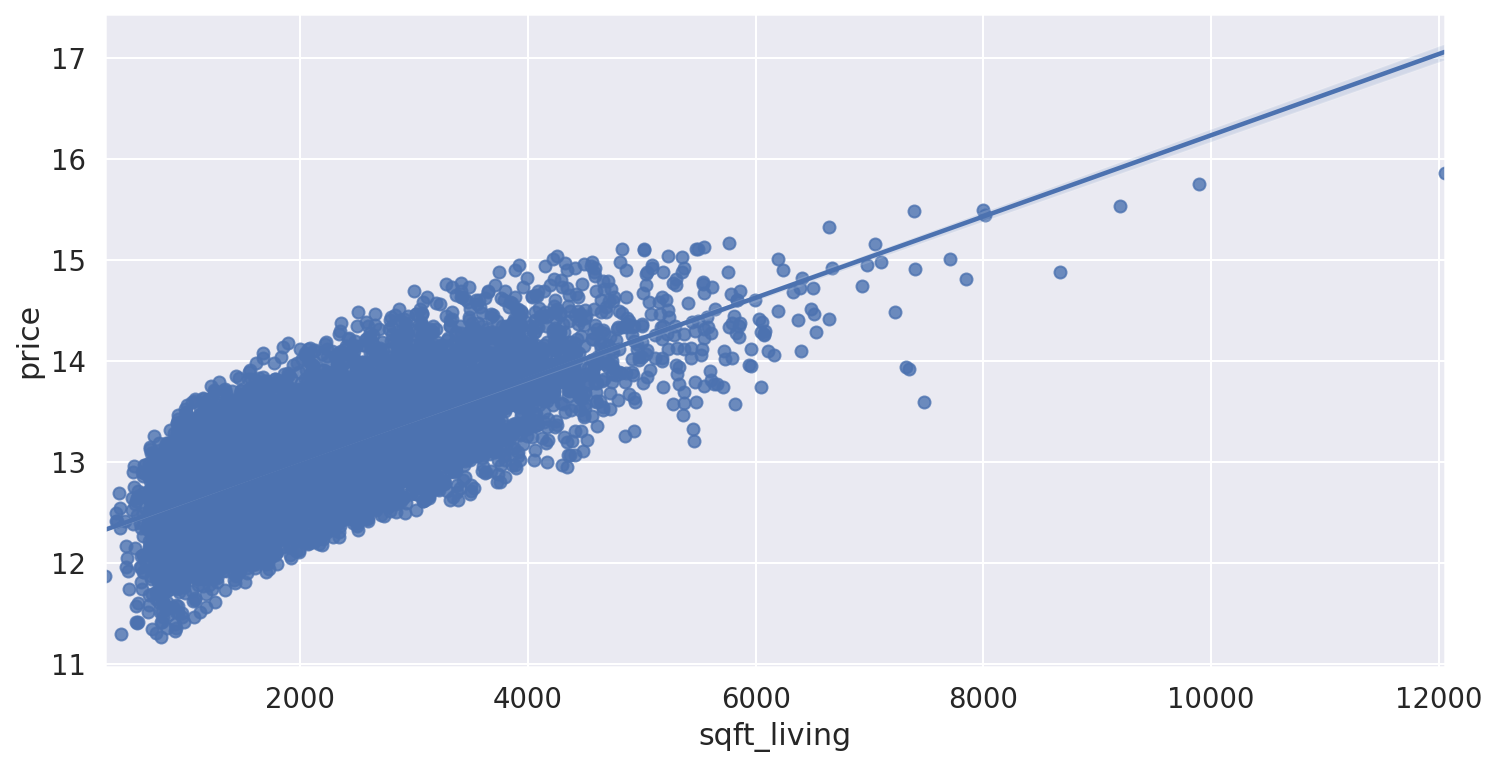

In [18]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(12,6))
fig = sns.regplot(x='sqft_living', y='price', data=data)

* sqft_living15
<br> 이상치가 식별되지 않음 </br>

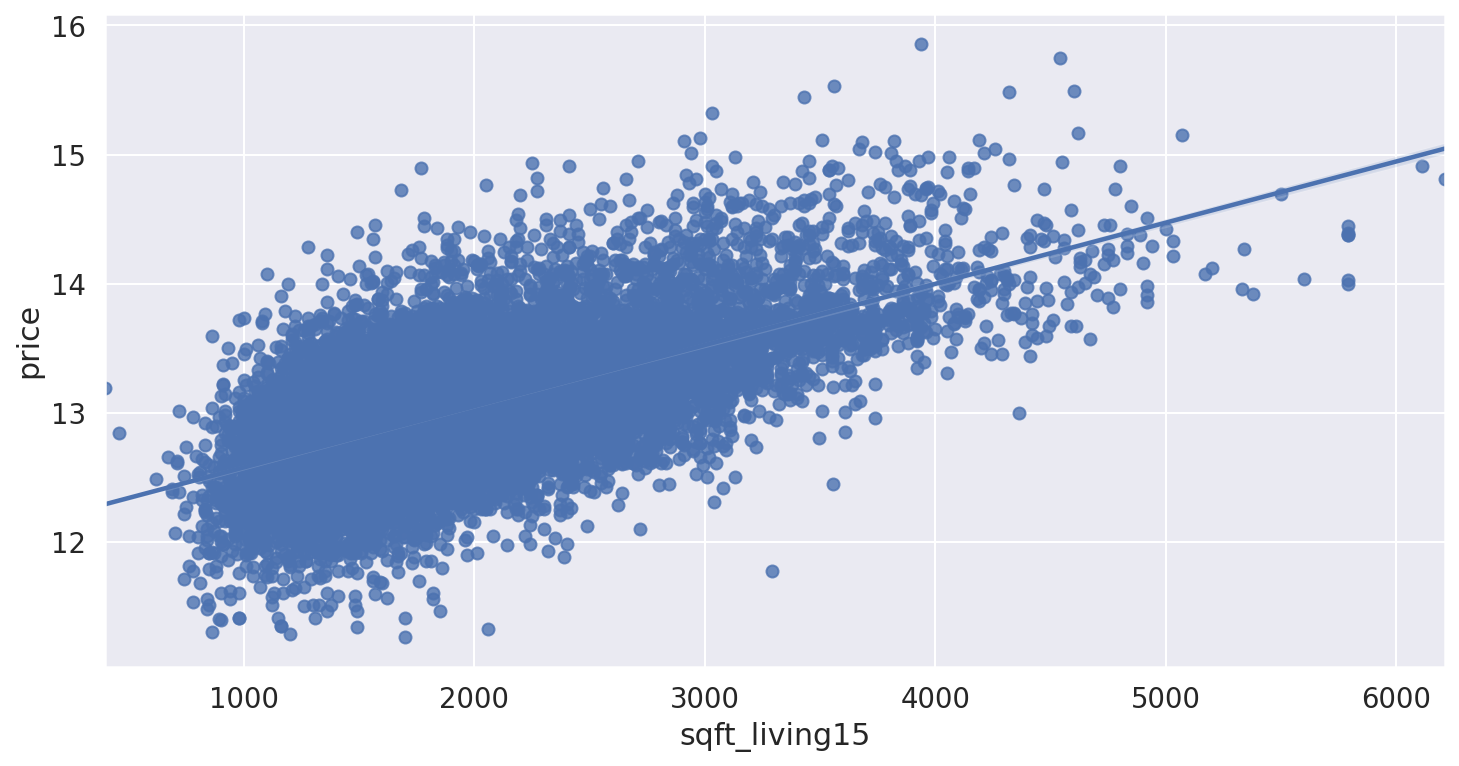

In [19]:
data = pd.concat([train['price'], train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(12,6))
fig = sns.regplot(x='sqft_living15', y='price', data=data)

* sqft_above
<br> 이상치가 식별되지 않음 </br>

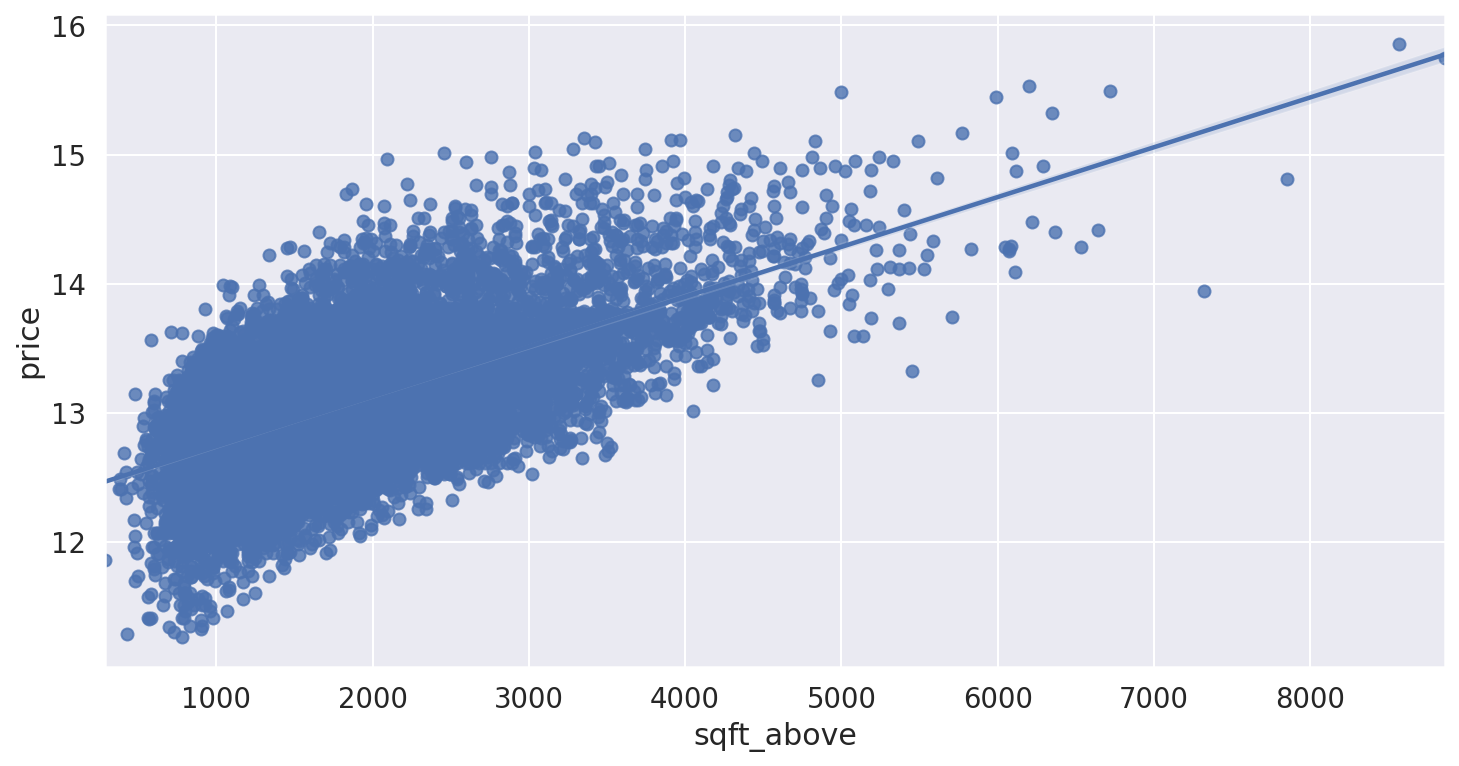

In [20]:
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(12,6))
fig = sns.regplot(x='sqft_above', y='price', data=data)

##### Y값 분리

In [21]:
#price 컬럼은 따로 y라는 변수에 저장한 후 해당 컬럼은 지워줍니다.
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 2.학습 데이터와 테스트 데이터 합치기

In [22]:
train_len = len(train)
train = pd.concat((train, test), axis=0)
print(len(train))

21499


#### 1-6. 결측치 확인
* 결측이 관찰되는 PRICE 컬럼은 목적변수

#### 결측치  확인


<AxesSubplot:>

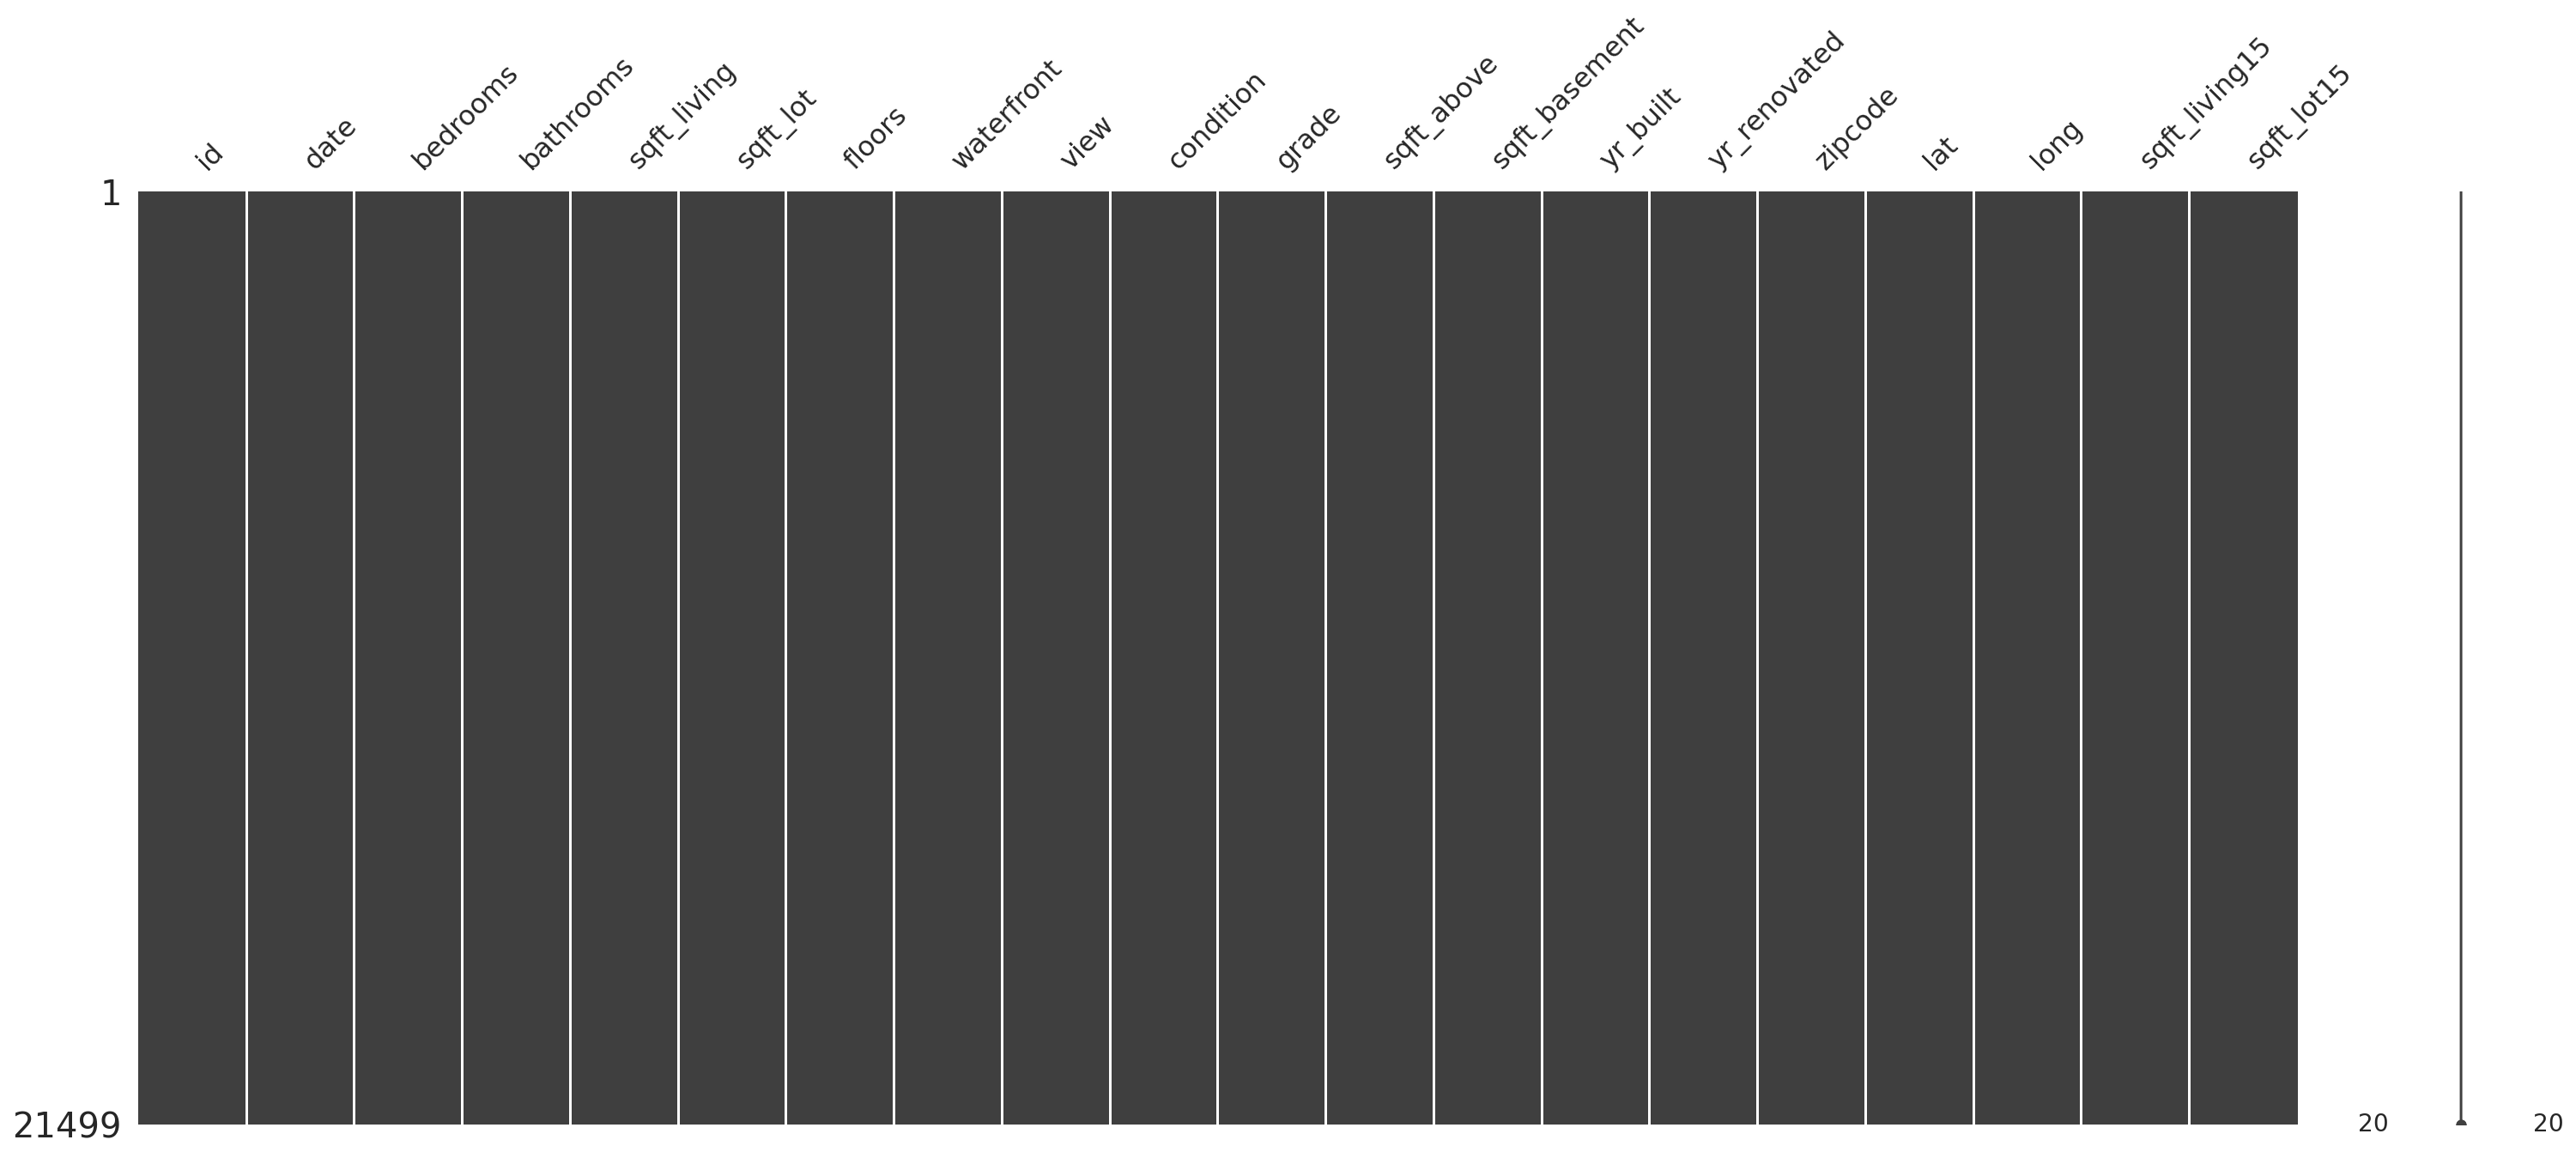

In [23]:
msno.matrix(train)

In [24]:
#결과 isnull 함수로 확인

for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 3. 데이터 전처리

#### 3-1. 불필요 데이터 정리 (가공, 제거)


In [25]:
test_id = train['id'][train_len:]

del train['id']

print(train.columns)  #ID 필드 정리 확인

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### 3-2. 반응 변수 시각화 

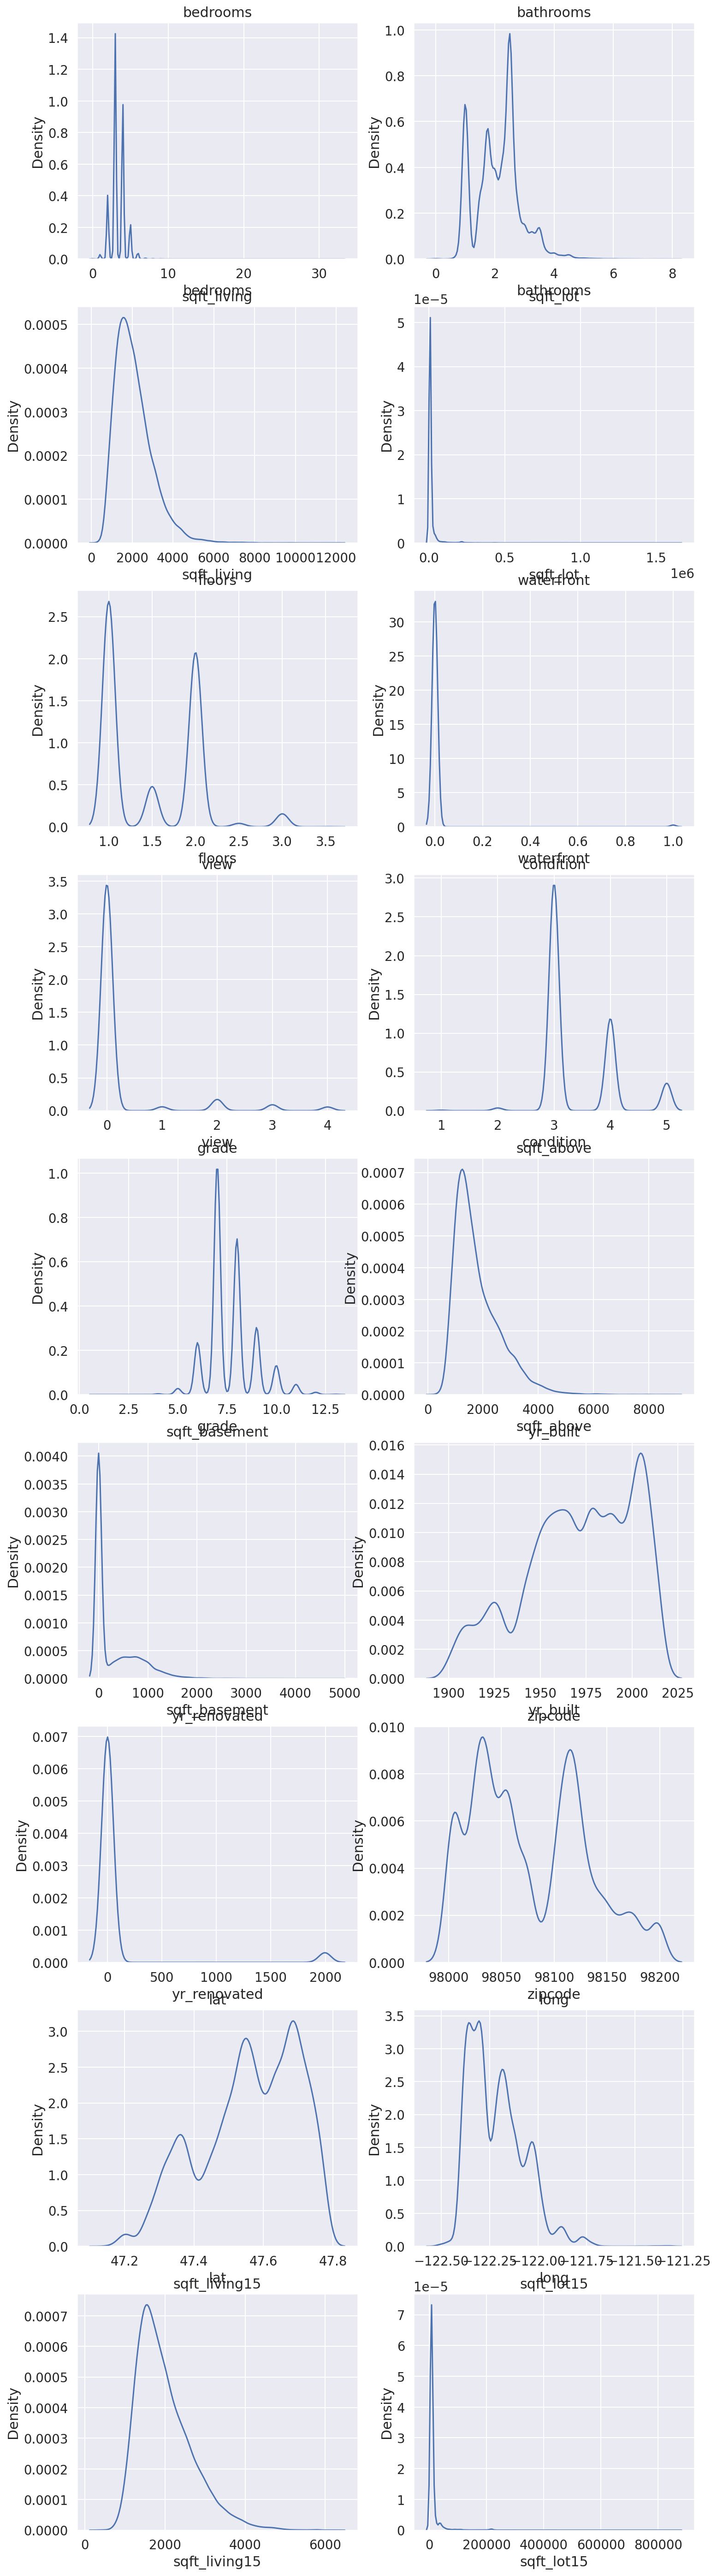

In [26]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1

#### 3-3. bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 노멀라이저 

In [27]:
#### 스피어만 상관 계수 10개 중 정규분포에 벗어난 반응 변수를 정규화
skew_columns =['sqft_living', 'sqft_living15','sqft_above', 'bathrooms',  'bedrooms' ,'floors','sqft_basement','sqft_lot']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

print('얍💢')

얍💢


#### 3-4. bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 노멀라이저 결과 확인

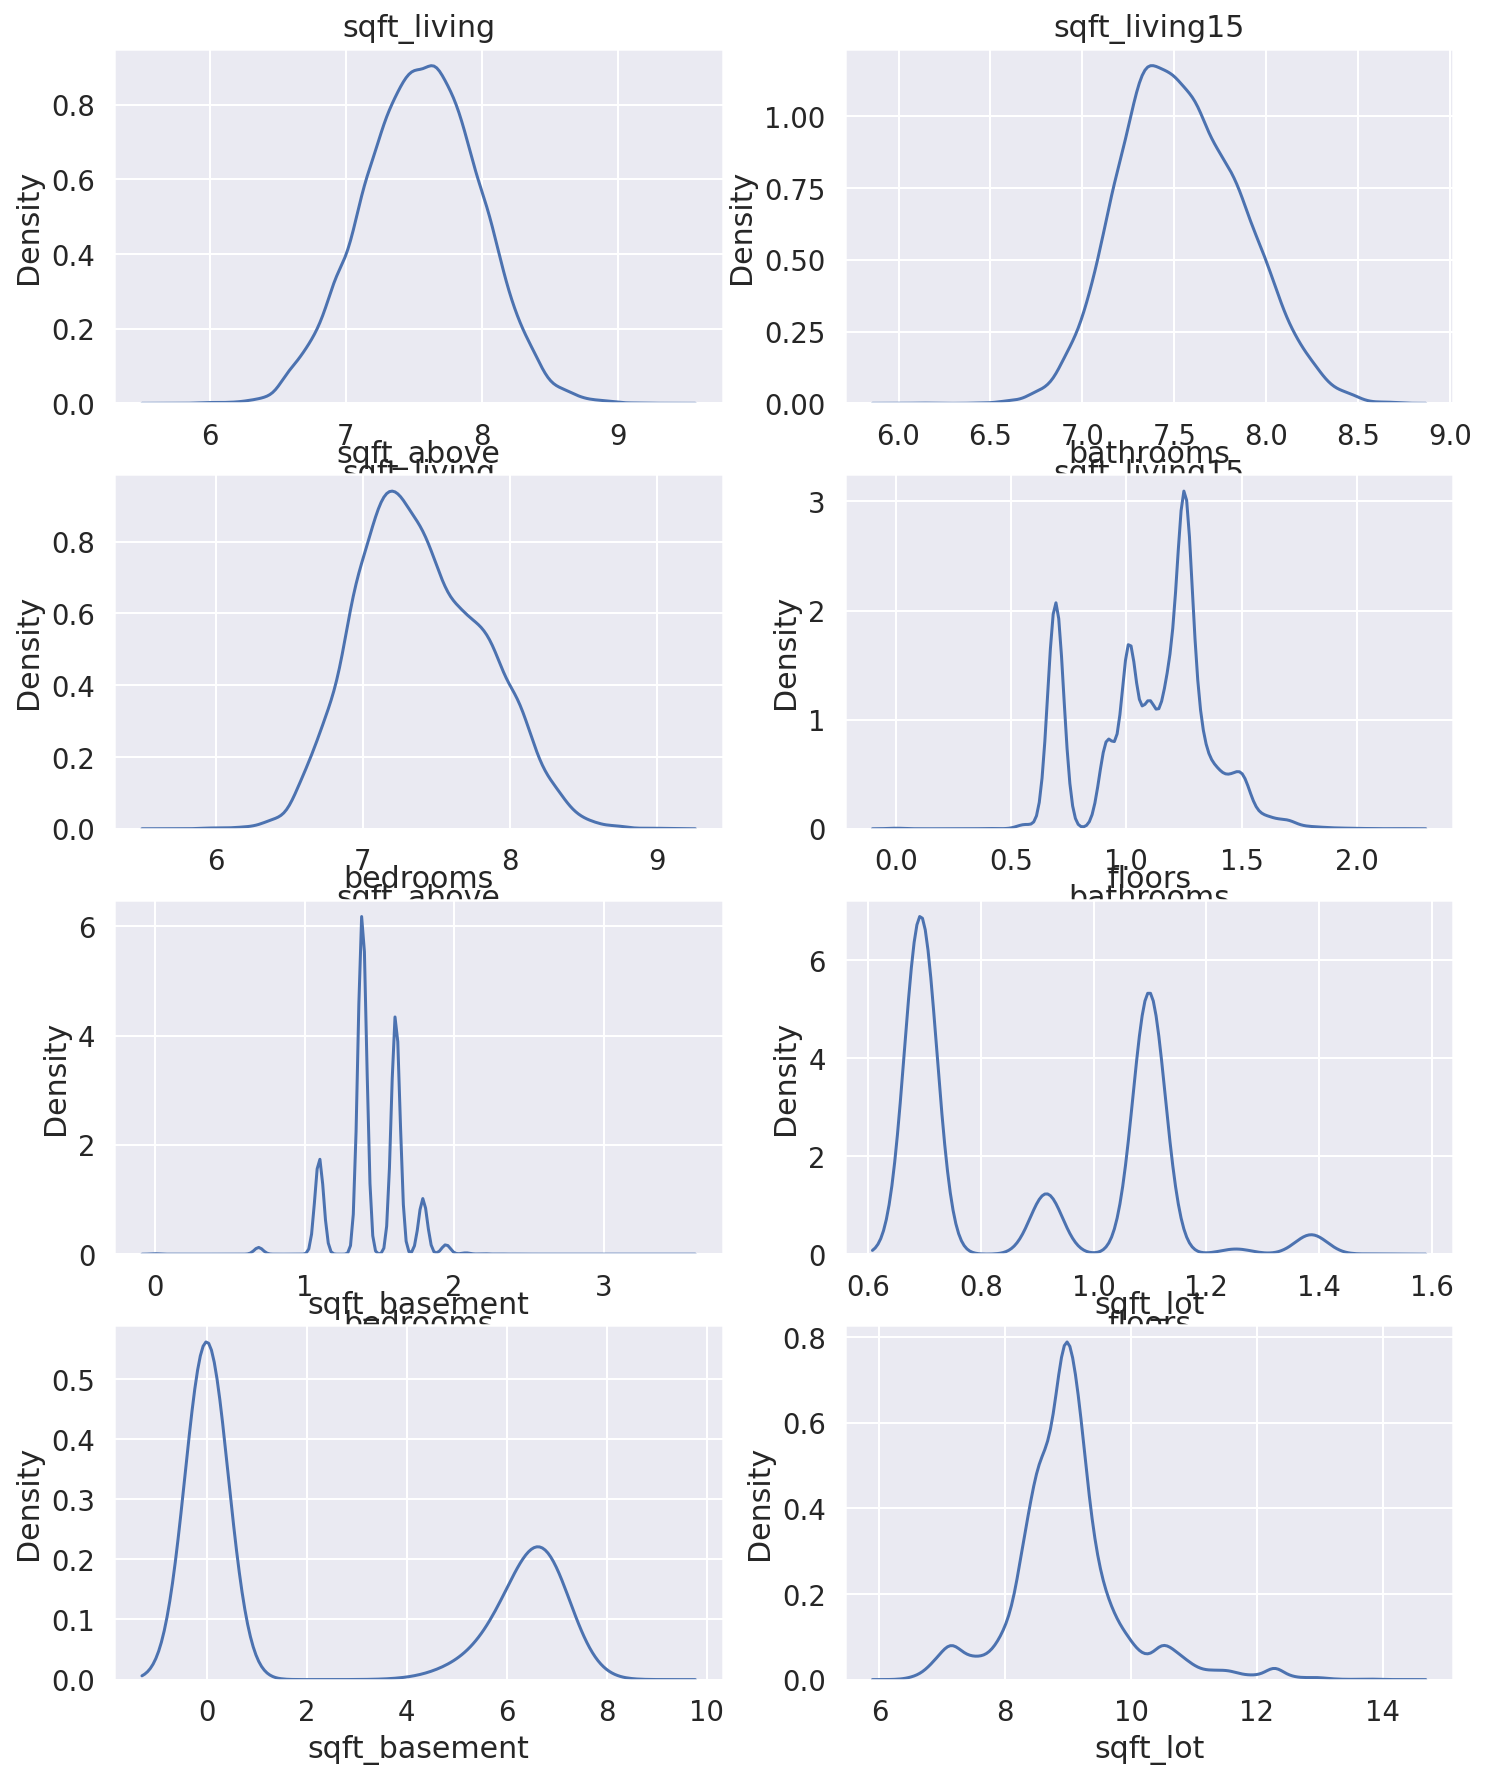

In [28]:
fig, ax = plt.subplots(4, 2, figsize=(12, 15))

count = 0
for row in range(4):
    for col in range(2):
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

#### 3-5. date 컬럼 정리

In [29]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,0.693147,7.074117,8.639588,0.693147,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,5650
1,201502,1.098612,0.693147,6.647688,9.210440,0.693147,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8062
2,201502,1.386294,1.098612,7.427144,8.997271,0.693147,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,7503
3,201406,1.386294,1.178655,7.447751,8.827615,1.098612,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,6819
4,201501,1.386294,0.916291,6.966967,9.181118,0.693147,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9711


#### 3-6.트레이닝할 데이터 처리 끝 결과 확인

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21499 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21499 non-null  int64  
 1   bedrooms       21499 non-null  float64
 2   bathrooms      21499 non-null  float64
 3   sqft_living    21499 non-null  float64
 4   sqft_lot       21499 non-null  float64
 5   floors         21499 non-null  float64
 6   waterfront     21499 non-null  int64  
 7   view           21499 non-null  int64  
 8   condition      21499 non-null  int64  
 9   grade          21499 non-null  int64  
 10  sqft_above     21499 non-null  float64
 11  sqft_basement  21499 non-null  float64
 12  yr_built       21499 non-null  int64  
 13  yr_renovated   21499 non-null  int64  
 14  zipcode        21499 non-null  int64  
 15  lat            21499 non-null  float64
 16  long           21499 non-null  float64
 17  sqft_living15  21499 non-null  float64
 18  sqft_lo

#### 3-7.붙였던 데이터 자르기

In [31]:
test = train.iloc[train_len:,:]
train = train.iloc[:train_len, :]


In [32]:
print(train.shape)
print(y.shape)
print(test.shape)

(15031, 19)
(15031,)
(6468, 19)


-----
-----

### 4.모델 설계

* 4가지를 활용
 * GradientBoosting
 * XGBoosting
 * LightGBM
 * RandomForest

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

얍💢


In [53]:
## 결과 평가 하는 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


In [54]:
# 모델은 4가지로 해본다
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


#### 4-1. 모델의 디폴트 하이퍼 파라미터로 샘플링 80:20 데이터분할  학습 진행


In [55]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  

random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [56]:
def get_scores(models, train, y):
    df = {}
    # 답안 작성
    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] =rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df
        

In [57]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,136596.638157
RandomForestRegressor,122508.094222
XGBRegressor,114122.417162
LGBMRegressor,113045.227637


### 4-2. 하이퍼파라미터 튜닝

In [39]:
from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


In [64]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE', ascending=True).head(5)

    return results

In [41]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

### 1. lightGBM

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {
         'num_leaves': [31],
         'min_data_in_leaf': [30], 
         'objective':['regression'],
         'max_depth': [5, 10, -1],
         'min_child_samples': [20],
         'boosting': ['gbdt'],
         'feature_fraction': [0.9],
         'bagging_freq': [1],
         'bagging_fraction': [0.9] ,
         'bagging_seed': [11],
         'metric': ['rmse'],
         'lambda_l1': [0.1],
         'verbosity': [-1],
         'nthread': [4]
}

#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html

my_GridSearch(lightgbm, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    1.3s finished


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


,bagging_fraction,bagging_freq,bagging_seed,boosting,feature_fraction,lambda_l1,max_depth,metric,min_child_samples,min_data_in_leaf,nthread,num_leaves,objective,verbosity,score,RMSLE
2,0.9,1,11,gbdt,0.9,0.1,-1,rmse,20,30,4,31,regression,-1,-0.026708,0.163425
1,0.9,1,11,gbdt,0.9,0.1,10,rmse,20,30,4,31,regression,-1,-0.026751,0.163559
0,0.9,1,11,gbdt,0.9,0.1,5,rmse,20,30,4,31,regression,-1,-0.028542,0.168942


In [72]:
'''
bagging_fraction	bagging_freq	bagging_seed	boosting	feature_fraction	lambda_l1	max_depth	metric	min_child_samples	min_data_in_leaf	nthread	num_leaves	objective	verbosity	score	RMSLE
2	0.9	1	11	gbdt	0.9	0.1	-1	rmse	20	30	4	31	regression	-1	-0.026708	0.163425

'''

#최적화된 하이퍼 파라미터로 모델 재정의
#lightgbm = LGBMRegressor( boosting_type='gbdt', learning_rate=0.03, max_depth=-1,  num_iterations=1000,  random_state=random_state)

#score를 올리기 위해 파라미터 최적값을 넣어보겠다. Gridsearch로 찾는데 컴퓨팅 파워가 부족하다.
#lightgbm = LGBMRegressor(bagging_fraction=0.9 , bagging_freq =1, bagging_seed=11, boosting='gbdt', feature_fraction=0.9
#                         , lambda_l1=0.1, max_depth=-1,metric='rmse', min_child_samples=20
#                         , min_data_in_leaf=30
#                         , nthread=4
#                         , objective ='regression'
#                         , verbosity= -1
#                         , random_state=random_state)

lightgbm = LGBMRegressor(objective='regression',num_leaves=31,
                              learning_rate=0.015, n_estimators=8000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 1, feature_fraction = 0.9,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_child_samples = 20, reg_alpha= 0.1
                    )
#boosting_type='gbdt', learning_rate=0.03, max_depth=-1,  num_iterations=1000, verbosity= -1, random_state=4950)



### 2. RF Regressor

In [59]:
param_grid =   {
    'n_estimators': [500, 1000],
    'bootstrap': [True, False],
    'max_depth': [10, 15],
}
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
my_GridSearch(rdforest, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  5.4min
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:  7.1min finished


,bootstrap,max_depth,n_estimators,score,RMSLE
3,True,15,1000,-0.031642,0.177883
2,True,15,500,-0.031699,0.178042
1,True,10,1000,-0.034766,0.186457
0,True,10,500,-0.034780,0.186494
5,False,10,1000,-0.049422,0.222310


In [71]:
'''
bootstrap	max_depth	n_estimators	score	RMSLE
True	15	1000	-0.031642	0.177883'''

#rdforest = RandomForestRegressor(bootstrap=True, max_depth=15, n_estimators=1000, n_jobs=5,  random_state=42)
rdforest = RandomForestRegressor(max_depth = 8, 
                                n_estimators = 8000,
                                max_features = 'sqrt', 
                                n_jobs = -1
                                )


### 3. XGBoost

In [65]:
param_grid = {
    'eta': [0.01],
    'max_depth': [6],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'objective': ['reg:linear'],
    'eval_metric': ['rmse']
}
#https://xgboost.readthedocs.io/en/latest/parameter.html

my_GridSearch(xgboost, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.3min remaining:  7.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.3min finished


[22:44:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


,colsample_bytree,eta,eval_metric,max_depth,objective,subsample,score,RMSLE
0,0.8,0.01,rmse,6,reg:linear,0.8,-0.028701,0.169414


In [69]:
'''
	colsample_bytree	eta	eval_metric	max_depth	objective	subsample	score	RMSLE
0	0.8	0.01	rmse	6	reg:linear	0.8	-0.028701	0.169414
'''

#xgboost = XGBRegressor(eta=0.01, max_depth=6, subsample=0.8, colsample_bytree=0.8, objective='reg:linear', eval_metric='rmse')
xgboost = XGBRegressor(ecolsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=8000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1
                      )
#xgboost = XGBRegressor(eta=0.02, max_depth=6, subsample=0.8, colsample_bytree=0.4)



### 4. GBoost

In [68]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [-1,  5, 10],
}
GBoost = GradientBoostingRegressor()
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.h#tml

my_GridSearch(gboost, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   22.7s
[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed:  2.3min finished


,max_depth,n_estimators,score,RMSLE
4,5,500,-0.026726,0.163480
5,5,1000,-0.026913,0.164052
3,5,100,-0.028660,0.169294
7,10,500,-0.029706,0.172353
6,10,100,-0.029706,0.172355


In [73]:
'''
max_depth	n_estimators	score	RMSLE
5	500	-0.026727	0.163483
'''

#최적화된 하이퍼 파라미터 셋팅
gboost = GradientBoostingRegressor(n_estimators=8000, learning_rate=0.05, max_depth=5,
                                   max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=4)





In [ ]:
#각 모델 별 최적 파라미터 (RMSLE 낮은) 에서의 수행 결과 기록
save_submission(lightgbm, train, y, test, 'LGBMRegressor', rmsle='0.160213')
save_submission(rdforest, train, y, test, 'RandomForestRegressor', rmsle='0.177883')
save_submission(xgboost, train, y, test, 'XGBRegressor', rmsle='0.169414')
save_submission(gboost, train, y, test, 'GradientBoostingRegressor', rmsle='0.163483')



##  앙상블

In [76]:
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBRegressor'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RandomForest'}]

def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=random_state).get_n_splits(train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train.values, y)),
                                                  kf=kfold))


In [ ]:
# 교차 검증 Cross Validatrion  모델 성능 평가
#get_cv_score(models)

In [77]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 

        m['model'].fit(
                x.values
               ,y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

## 블렌딩

In [78]:
# 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균
y_pred = AveragingBlending(models, train, y, test)
y_pred = np.expm1(y_pred)

[22:55:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { ecolsample_bytree, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


## 결과 저장

In [79]:
sub = pd.DataFrame(data={'id':test_id,'price':(y_pred)})
sub.head()

,id,price
0,15035,5.261273e+05
1,15036,4.613534e+05
2,15037,1.280124e+06
3,15038,2.954556e+05
4,15039,3.276325e+05


In [80]:
my_submission_path = join(data_dir, 'submission.csv')
sub.to_csv(my_submission_path, index=False)
print(my_submission_path)

/home/ssac15/aiffel/kaggle_kakr_housing/data/submission.csv


## 캐글 제출결과

![스크린샷, 2021-02-15 23-57-34](https://user-images.githubusercontent.com/76939885/107961857-c64e1080-6fe9-11eb-8e78-8d19272567ea.png)

## 총평

<br>루브릭 평가기준에 있는 score진입은 하늘의 별따기... </br>
<br>헤커톤 교내대회에서 이 모델로 성공해 보고 싶었으나.. 하늘의 별따기..</br>
<br>나의 첫 캐글 경진대회는 하늘의 별따기..</br>
<br>상위 score의 하이퍼 파라미터를 반영해 봐도 평가 기준내에 진입할 수가 없었다. </br>
<br>배운것은 많은 것 같은데.. 제일 속쓰린 Exploration이었다. </br>